# Importing and Parsing Strava Datasets

This notebook will parse all Strava GPX files and construct the necessary database.

## Step 0:  Global Parameters


In [1]:
database_path = 'bike_data.db'
epsg_code = 32613

### Caveats:

* Dataset on November 20 starts too late into sector 1 to be useful.  For ease, all sector 1 points on that dataset will be excluded for sector starting and ending points
* Dataset on December 9 starts about 1/3 of the way through sector-0.  For ease, all sector 0 points on that dataset will be excluded for sector starting and ending points.

## Step 1: Import required libraries

In [2]:
import gpxpy
import datetime
from math import sqrt, floor
import numpy as np
import pandas as pd
import os, re
import sqlite3 as sql
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Proj, Transformer
import geopy.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib as mpl
from matplotlib import cm

## Step 2: Remove the database and re-initialize

In [3]:
if os.path.exists( database_path ):
    print('Removing {}'.format( database_path ))
    os.remove( database_path )
    
conn = sql.connect( database_path )

Removing bike_data.db


Setup the projection.

In [4]:
#  Setup the Projection Transformer
crs = CRS.from_epsg( epsg_code )
proj = Transformer.from_crs(crs.geodetic_crs, crs)
utm_zone = int(re.findall("\d+", crs.utm_zone)[0])
print('UTM Zone: {}'.format(utm_zone))

UTM Zone: 13


### Database Tables

#### sector_list

This table contains the list of sectors, the number of points in each, and it's name.

| index          | sector_name  | sector_id    |  number_points |
| :------------- | :----------- | :----------- | :------------- |
|  Integer       | String       | String       | Integer        |
|  0             | Sector 1     | sector_1     | 14             |

* Sector Name: 
  * Descriptive name of the sector.
* Sector-ID: 
  * Table that contains the point data.
* Number-Points:
  * Number of points in the table for the sector polygon.

#### sector_X

This table breaks down an individual sector.

| index   | latitude    | longitude   | elevation  |
| :------ | :---------- | :---------- | :--------- |
| Integer | Float       | Float       | Float      |
| 0       | 38.12345    | -104.1243   | 1713       |

#### point_list

This table contains the full list of points collected from GPX files.

| index   | longitude | latitude  | elevation | timestamp                 | step_dist    | time_diff_sec | sector_id | dataset                      | dataset_id |
| :------ | :-------- | :-------- | :-------- | :------------------------ | :----------- | :------------ | :-------- | :--------------------------- | :--------- |
| Integer | Float     | Float     | Float     | String                    | Float        | Float         | String    | String                       | Integer    |
|   3     | 39.12345  | -104.1234 | 1713.123  | 2020-11-20 00:03:18+00:00 | 3.7842052780 | 1             | sector_1  | ./datasets/ride.20201120.gpx | 1          |

## Step 3:  Load the Sector Polygons

In order to classify each track point, we need to assign it to a sector.  The sector KML file has each sector in the form of a KML polygon.  This block will load the sector KML file and load the sectors into the database.

In [5]:
# Load the sector map
import KML_Parser
kml_file = KML_Parser.Bike_Sector_KML_File()
bike_sector_polygons = kml_file.Parse_KML( 'bike_sectors.kml' )

#  Create a table list
table_list = ['sector_' + str(x) for x in range(0, len(bike_sector_polygons))]
dataset = { 'sector_name'  : [ x['name'] for x in bike_sector_polygons ],
            'sector_id'    : table_list,
            'number_points': [ len(x['polygon']) for x in bike_sector_polygons ] }
pd.DataFrame( data = dataset ).to_sql( 'sector_list', conn )

#  Create a table for each sector
counter = 0
for sector in bike_sector_polygons:
    table_name = table_list[counter]
    dataset = { 'latitude':  [ x[1] for x in sector['polygon'] ],
                'longitude': [ x[0] for x in sector['polygon'] ],
                'gridZone':  [ utm_zone for x in sector['polygon'] ],
                'isNorth':   [ True for x in sector['polygon'] ],
                'easting':   [ 0    for x in sector['polygon'] ],
                'northing':  [ 0    for x in sector['polygon'] ],
                'elevation': [ x[2] for x in sector['polygon'] ] }
    
    #  Compute UTM Coordinates
    for x in range( 0, len(sector['polygon'])):
        (easting, northing) = proj.transform( sector['polygon'][x][1],
                                              sector['polygon'][x][0] )
        dataset['easting'][x]  = easting
        dataset['northing'][x] = northing
    
    pd.DataFrame( data = dataset ).to_sql( table_name, conn )
    
    #  Create Shapely Polygon to Aid Point-in-Polygon Searches
    bike_sector_polygons[counter]['shape']     = Polygon( [ (x[0], x[1]) for x in sector['polygon'] ] )
    bike_sector_polygons[counter]['sector_id'] = table_name
    
    counter += 1


In order to map points to sectors, we need a lookup method.

In [6]:
def Find_Sector( sector_polygon_list, point ):
    
    #  Iterate over each polygon
    for x in range( 0, len( sector_polygon_list ) ):
        if sector_polygon_list[x]['shape'].contains( point ):
            return sector_polygon_list[x]['sector_id']
              

## Step 4: Load the GPX Data and write to the database

This is a multi-step process.
* Load each GPX Dataset
* For each dataset
  * Assign a sector
* Write all points to the database

In [7]:
#  Look for GPX Files
dataset_id = 0
df = pd.DataFrame( columns=['longitude',
                            'latitude',
                            'gridZone',
                            'easting',
                            'northing',
                            'elevation',
                            'timestamp', 
                            'stepDist',
                            'elapsedDist',
                            'timeDiffSec',
                            'sectorId',
                            'dataset',
                            'datasetId'])
dataset_id_lut = {}
for root, dirs, files in os.walk( "./datasets", topdown=False ):
    for name in files:
        fname = os.path.join( root, name )
        if os.path.splitext( fname )[-1] == '.gpx':
            print('Loading: {}, Dataset-ID: {}'.format( fname, dataset_id ))
            dataset_id_lut[fname] = dataset_id
            gpx_file = open( fname )
            gpx_data = gpxpy.parse( gpx_file )
            
            point_data = gpx_data.tracks[0].segments[0].points
            
            first_point = True
            prev_point = None
            distance_elapsed = 0
            for point in point_data:
                
                #  Assign a sector-id to the point
                sector_id = Find_Sector( bike_sector_polygons, Point([point.longitude, point.latitude]) )
                time_diff = 0
                distance_prev = 0
                if first_point:
                    first_point = False
                else:
                    distance_prev = geopy.distance.geodesic( (prev_point.latitude, prev_point.longitude),
                                                             (     point.latitude,      point.longitude) ).m
                    distance_elapsed += distance_prev
                    time_diff = ( point.time - prev_point.time).total_seconds()
                    
                (easting,northing) = proj.transform( point.latitude, point.longitude )
                #print( 'Point: {}, {}, Easting: {}, Northing: {}'.format( point.latitude, 
                #                                                          point.longitude,
                #                                                          easting,
                #                                                          northing))
                    
                df = df.append({'longitude'   : point.longitude, 
                                'latitude'    : point.latitude,
                                'gridZone'    : utm_zone,
                                'easting'     : easting,
                                'northing'    : northing,
                                'elevation'   : point.elevation,
                                'timestamp'   : str(point.time),
                                'stepDist'    : distance_prev,
                                'elapsedDist' : distance_elapsed,
                                'timeDiffSec' : time_diff,
                                'sectorId'    : sector_id,
                                'dataset'     : fname,
                                'datasetId'   : int(dataset_id) }, ignore_index=True )
                prev_point = point
                
            dataset_id += 1

df
df.to_sql( 'point_list', conn )
print('Database Written to Disk')

Loading: ./datasets/ride.20201123.gpx, Dataset-ID: 0
Loading: ./datasets/ride.20201120.gpx, Dataset-ID: 1
Loading: ./datasets/ride.20201130.gpx, Dataset-ID: 2
Loading: ./datasets/ride.20201209.gpx, Dataset-ID: 3
Database Written to Disk


## Step 5: Compute Sector Entry and Exit Points



In [8]:
#  For each sector, get the first and last points
sector_points = {}
sector_list = df.dropna()['sectorId'].unique()

for sector in sector_list:
    
    sector_points[sector] = {'start': [],
                             'end': [] }
    
    #  Get the list of points for the sector
    points_sector = df.loc[df['sectorId'] == sector]

    # Get unique dataset-ids for this sector
    dataset_ids = points_sector['datasetId'].unique()

    #  Caveat for 12/9 sector-0 exclusion
    if sector == 'sector_0':
        ids = np.in1d( dataset_ids, dataset_id_lut['./datasets/ride.20201209.gpx'] )
        dataset_ids = dataset_ids[~ids]
        display(dataset_ids)
    if sector == 'sector_1':
        ids = np.in1d( dataset_ids, dataset_id_lut['./datasets/ride.20201120.gpx'] )
        dataset_ids = dataset_ids[~ids]
        display(dataset_ids)
        
    #  Get earliest value for each dataset
    for dataset_id in dataset_ids:
    
        dataset_sector_points = points_sector.loc[points_sector['datasetId'] == dataset_id]
        
        first_point = dataset_sector_points.loc[dataset_sector_points['elapsedDist'] == dataset_sector_points.elapsedDist.min()]
        last_point  = dataset_sector_points.loc[dataset_sector_points['elapsedDist'] == dataset_sector_points.elapsedDist.max()]
        sector_points[sector]['start'].append([first_point.values[0][1],first_point.values[0][0]])
        sector_points[sector]['end'].append([last_point.values[0][1],last_point.values[0][0]])
    

#  Sector 0 uses just the first points as start
columns = ['sectorId','startLatitude','startLongitude','startEasting','startNorthing',
           'stopLatitude','stopLongitude','stopEasting','stopNorthing']

sector_data = []

#  Sectors 1-(last-1) use similar to the last of 0
for sector in range(0,len(sector_list)):

    sector_id = 'sector_' + str(sector)
    
    #  Get the current sector's points
    mean_start_lats = [ x[0] for x in sector_points[sector_id]['start']]
    mean_start_lons = [ x[1] for x in sector_points[sector_id]['start']]
    mean_stop_lats  = [ x[0] for x in sector_points[sector_id]['end']]
    mean_stop_lons  = [ x[1] for x in sector_points[sector_id]['end']]
    
    #  If we are not sector 0, then add the previous sectors' endpoints to the start list
    if sector != 0:
        mean_start_lats.extend( [x[0] for x in sector_points['sector_' + str(sector-1)]['end']] )
        mean_start_lons.extend( [x[1] for x in sector_points['sector_' + str(sector-1)]['end']] )
    
    #  If we are not the last sector, then add the next sector's start points to the end list
    if sector != (len(sector_list)-1):
        mean_stop_lats.extend( [x[0] for x in sector_points['sector_' + str(sector+1)]['start']] )
        mean_stop_lons.extend( [x[1] for x in sector_points['sector_' + str(sector+1)]['start']] )
    
    # Compute the mean values
    mean_start_lat = np.array( mean_start_lats ).mean()
    mean_start_lon = np.array( mean_start_lons ).mean()
    mean_stop_lat = np.array( mean_stop_lats ).mean()
    mean_stop_lon = np.array( mean_stop_lons ).mean()
    
    (mean_start_east,mean_start_north) = proj.transform( mean_start_lat, mean_start_lon )
    (mean_stop_east, mean_stop_north)  = proj.transform( mean_stop_lat,  mean_stop_lon )

    sector_data.append([sector_id,mean_start_lat,mean_start_lon,mean_start_east,mean_start_north,mean_stop_lat,mean_stop_lon,mean_stop_east,mean_stop_north])

sector_waypoints = pd.DataFrame( data = sector_data, columns=columns )
sector_waypoints.to_sql( 'sector_point_list', conn )
display(sector_waypoints)

array([0, 2], dtype=object)

array([0, 2, 3], dtype=object)

,sectorId,startLatitude,startLongitude,startEasting,startNorthing,stopLatitude,stopLongitude,stopEasting,stopNorthing
0,sector_0,39.598926,-104.860817,511949.837255,4.383253e+06,39.624242,-104.868715,511267.650791,4.386061e+06
1,sector_1,39.624242,-104.868715,511267.650791,4.386061e+06,39.645169,-104.869305,511213.641513,4.388384e+06
2,sector_2,39.645169,-104.869305,511213.641513,4.388384e+06,39.658127,-104.862983,511753.860232,4.389823e+06
3,sector_3,39.658127,-104.862983,511753.860232,4.389823e+06,39.674841,-104.893981,509092.539886,4.391674e+06
4,sector_4,39.674841,-104.893981,509092.539886,4.391674e+06,39.696804,-104.922328,506659.321378,4.394109e+06
5,sector_5,39.696804,-104.922328,506659.321378,4.394109e+06,39.715804,-104.959213,503495.956483,4.396216e+06
6,sector_6,39.715804,-104.959213,503495.956483,4.396216e+06,39.721217,-104.979653,501743.856253,4.396816e+06
7,sector_7,39.721217,-104.979653,501743.856253,4.396816e+06,39.740115,-104.998209,500153.478631,4.398913e+06
8,sector_8,39.740115,-104.998209,500153.478631,4.398913e+06,39.754884,-105.000055,499995.267057,4.400552e+06


## Step 6: Visualize Results

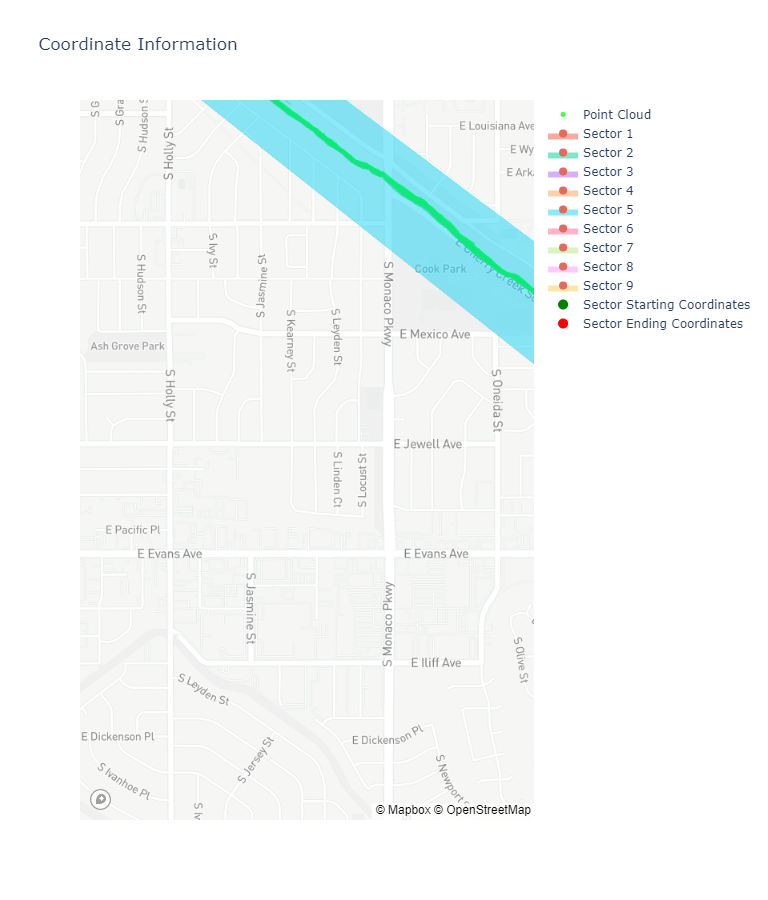

In [11]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure()

cmap = mpl.cm.get_cmap('Spectral')

        
#  Add Points
fig.add_trace(go.Scattermapbox(
        lat=df['latitude'],
        lon=df['longitude'],
        mode='markers',
        name='Point Cloud',
        marker=go.scattermapbox.Marker( size=5,
                                        color='rgb(0, 255, 0)',
                                        opacity=0.7 )
    ))

#  Add Sector Polygons
counter = 0

#  Add start for sector 0
for sector in bike_sector_polygons:
    
    lat_list = []
    lon_list = []
    for p in sector['polygon']:
        lat_list.append(p[1])
        lon_list.append(p[0])
    
    #  Assign a color
    color_val = cmap(float(0)/len(bike_sector_polygons))
        
    #  Render
    fig.add_trace( go.Scattermapbox( fill = "toself",
                                     lon=lon_list,
                                     lat=lat_list,
                                     name=sector['name'],
                                     marker = { 'size': 8,
                                                'color': color_val }))
    counter += 1

#  Add the entry and exit points
fig.add_trace( go.Scattermapbox( lon=sector_waypoints['startLongitude'],
                                 lat=sector_waypoints['startLatitude'],
                                 name='Sector Starting Coordinates',
                                 marker = { 'size': 10,
                                            'color': 'green' }))

fig.add_trace( go.Scattermapbox( lon=sector_waypoints['stopLongitude'],
                                 lat=sector_waypoints['stopLatitude'],
                                 name='Sector Ending Coordinates',
                                 marker = { 'size': 10,
                                            'color': 'red' }))
    
fig.update_layout(
    title='Coordinate Information',
    autosize=True,
    hovermode='closest',
    showlegend=True,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=df['latitude'].mean(),
            lon=df['longitude'].mean()
        ),
        pitch=0,
        zoom=14,
        style='light'
    ),
    height=900,
)
    
fig.show()